In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import glob

import tensorflow as tf

from sklearn.cluster import KMeans
from numpy import unique
from numpy import where
from matplotlib import pyplot
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import AgglomerativeClustering

from tensorflow import keras
from tensorflow.keras import layers
#import tensorflow_decision_forests as tfdf

from sklearn.datasets import make_classification

print(tf.__version__)

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

2.8.0


### Club all the traces together into a single dataframe

In [25]:
path = './traces_core'# use your path
#all_files = glob.glob(path + "/*.h5")
all_files = glob.glob(path + "/dpotrf_T-200_C-8-*.prof*")

li = []

for filename in all_files:
    trace =  pd.HDFStore(filename)
    data = trace.get('/events')
    trace.close()
    
    li.append(data)
    print(filename)

df = pd.concat(li, axis=0, ignore_index=True)


./traces_core/dpotrf_T-200_C-8-1.prof.h5
./traces_core/dpotrf_T-200_C-8-0.prof.h5


In [26]:
print(len(li))

2


# Clean the data

In [27]:
df = df[['begin', 'end', 'taskpool_id', 'task_class_id','chore_id', 'nb_data_items', 'total_data_size', 'priority']].copy()
df['exec_time'] = (df['end'] - df['begin']) * .001 #0.001 nano seconds to micro seconds
df = df.astype(float)

In [28]:
df_class_name = {0: 'dpotrf', 1: 'dtrsm', 2: 'dsyrk', 3: 'dgemm'}

In [29]:

filter = ( (df['task_class_id'] >= 0 ) & ( df['task_class_id'] <= 3 ) & ( df['priority'] >= 0 ) )
#remove all other classes other than dpotrf, dgemm, trsm and syrk
df = df[filter]
df.head()

,begin,end,taskpool_id,task_class_id,chore_id,nb_data_items,total_data_size,priority,exec_time
29700,351909.0,1137912.0,2.0,2.0,0.0,1.0,320000.0,0.0,786.003
29701,1152037.0,1978760.0,2.0,1.0,0.0,2.0,320000.0,0.0,826.723
29702,1992319.0,3332333.0,2.0,1.0,0.0,2.0,320000.0,0.0,1340.014
29703,3345388.0,4463062.0,2.0,2.0,0.0,1.0,320000.0,0.0,1117.674
29704,4477110.0,4751604.0,2.0,1.0,0.0,2.0,320000.0,0.0,274.494


## integrate likelihood of the data being in cash.
we assume that all the task whose execution time is in the first quartile could have had all its data in the cache. While, the rest of the tasks would have resulted in a cache flush. While predicting we assume that the that the data of the task is not in the cache 

In [30]:
df[df['task_class_id'] == 3].head()

,begin,end,taskpool_id,task_class_id,chore_id,nb_data_items,total_data_size,priority,exec_time
30039,1.175953e+09,1.176501e+09,4.0,3.0,0.0,3.0,960000.0,779276.0,547.262
30041,1.204766e+09,1.205336e+09,4.0,3.0,0.0,3.0,960000.0,756955.0,570.057
30042,1.205356e+09,1.205912e+09,4.0,3.0,0.0,3.0,960000.0,665169.0,556.249
30043,1.205932e+09,1.206489e+09,4.0,3.0,0.0,3.0,960000.0,710585.0,557.162
30044,1.206510e+09,1.207056e+09,4.0,3.0,0.0,3.0,960000.0,731784.0,545.922


In [31]:
df.reset_index(inplace=True)

----------------- dpotrf [before] -------------------------- 
Min = 273.943
Max = 10116.755000000001
Avg = 384.86553
Std = 822.3202862288073
----------------- dpotrf [after] -------------------------- 
Min = 277.117
Max = 327.813
Avg = 301.6898483754513
Std = 11.166989913929191
datapoints removed 7.666666666666666%
----------------- dtrsm [before] -------------------------- 
Min = 255.084
Max = 143255.413
Avg = 906.0237415824984
Std = 2803.5631922934954
----------------- dtrsm [after] -------------------------- 
Min = 255.084
Max = 962.3240000000001
Avg = 448.15446103121326
Std = 154.81940522754834
datapoints removed 4.006734006734006%
----------------- dsyrk [before] -------------------------- 
Min = 160.572
Max = 68134.695
Avg = 846.1329274587457
Std = 2256.849572203497
----------------- dsyrk [after] -------------------------- 
Min = 346.589
Max = 516.573
Avg = 420.7954304439138
Std = 32.96111071868181
datapoints removed 8.85148514851485%
----------------- dgemm [before] -----------

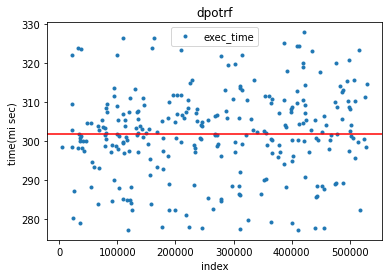

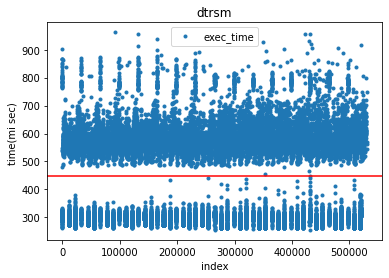

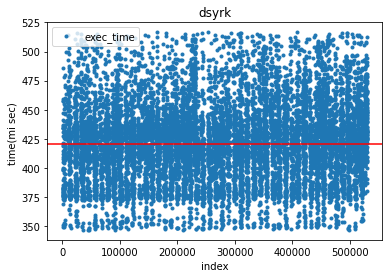

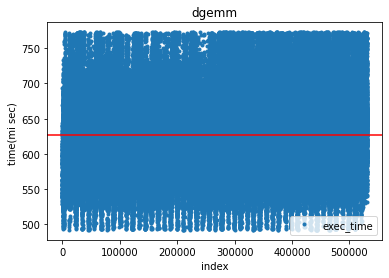

In [32]:
task_class_id = [0,1,2,3]

for i in task_class_id:
    
    df_exaxmple = df
    
    filter = (df_exaxmple['task_class_id'] == i )
    df_refined = df_exaxmple[filter]
    
    print('----------------- ' + df_class_name[i] + ' [before] -------------------------- ')
    print('Min = ' + str(df_refined['exec_time'].min()))
    print('Max = ' + str(df_refined['exec_time'].max()))
    print('Avg = ' + str(sum(df_refined['exec_time']) / len(df_refined['exec_time'])))
    print('Std = ' + str(df_refined['exec_time'].std()))
    datapoint1 = df_refined.shape[0]
    
    Q1 = df_refined['exec_time'].quantile(0.25)
    Q3 = df_refined['exec_time'].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range.
    filter = (df_refined['exec_time'] >= Q1 - 1.5 * IQR) & (df_refined['exec_time'] <= Q3 + 1.5 *IQR)
    df_refined = df_refined.loc[filter]
    df_refined = df_refined.astype(float)
    
    print('----------------- ' + df_class_name[i] + ' [after] -------------------------- ')
    print('Min = ' + str(df_refined['exec_time'].min()))
    print('Max = ' + str(df_refined['exec_time'].max()))
    print('Avg = ' + str(sum(df_refined['exec_time']) / len(df_refined['exec_time'])))
    print('Std = ' + str(df_refined['exec_time'].std()))
    datapoint2 = df_refined.shape[0]
    
    perc_of_data = (datapoint1 - datapoint2) / datapoint1 * 100
    print('datapoints removed ' + str(perc_of_data) + '%')
    
    ax = df_refined.plot(y='exec_time',  use_index=True,
                    ylabel='time(mi sec) ', xlabel='index',
                    marker='.', linestyle='none',
                    title=df_class_name[i])
    ax.axhline(sum(df_refined['exec_time']) / len(df_refined['exec_time']), c='r')
    plt.savefig(df_class_name[i]+'_cloud', dpi=300)
    
    

## K-means

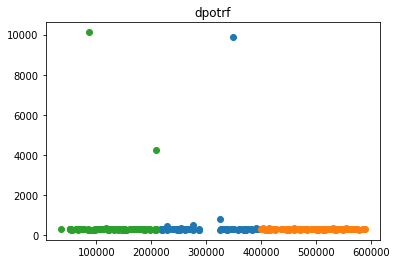

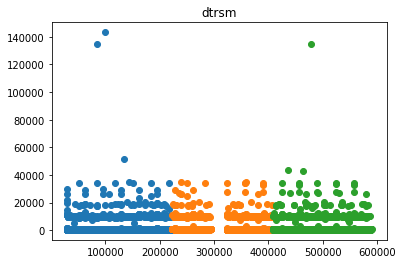

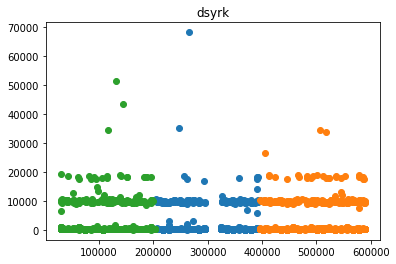

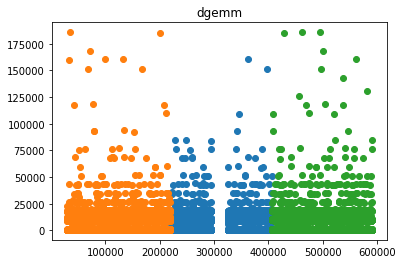

In [33]:
task_class_id = [0,1,2,3]

for i in task_class_id:
    # define dataset
    df_exaxmple = df
    filter = (df_exaxmple['task_class_id'] == i )
    df_refined = df_exaxmple[filter]
    x = df_refined[['index', 'exec_time']].copy()
    X = x.to_numpy()
    # define the model
    model = KMeans(n_clusters=3)
    # fit the model
    model.fit(X)
    # assign a cluster to each example
    yhat = model.predict(X)
    # retrieve unique clusters
    clusters = unique(yhat)
    # create scatter plot for samples from each cluster
    for cluster in clusters:
        # get row indexes for samples with this cluster
        row_ix = where(yhat == cluster)
        # create scatter of these samples
        pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
        pyplot.title(df_class_name[i])
    # show the plot
    pyplot.show()

## Reorder

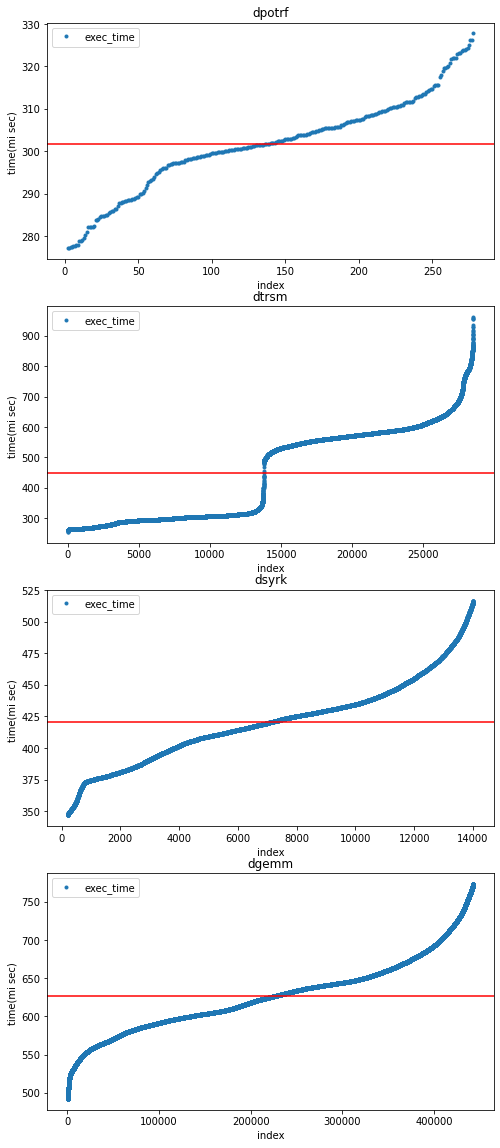

In [35]:
task_class_id = [0,1,2,3]
fig, axs = plt.subplots(4)
for i in task_class_id:
    
    df_exaxmple = df
    
    filter = (df_exaxmple['task_class_id'] == i )
    df_refined = df_exaxmple[filter]
    df_refined = df_refined.sort_values('exec_time', axis=0, ascending=True, 
                                        inplace=False, kind='quicksort', na_position='last')
    df_refined.insert(0, 'new_index', range(0, len(df_refined)))
    
    #print(df_refined.head())
    
    
    Q1 = df_refined['exec_time'].quantile(0.25)
    Q3 = df_refined['exec_time'].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range.
    filter = (df_refined['exec_time'] >= Q1 - 1.5 * IQR) & (df_refined['exec_time'] <= Q3 + 1.5 *IQR)
    df_refined = df_refined.loc[filter]
    df_refined = df_refined.astype(float)
    
    
    
    ax = df_refined.plot(y='exec_time',  x='new_index',
                    ylabel='time(mi sec) ', xlabel='index',
                    marker='.', linestyle='none',
                    title=df_class_name[i], ax=axs[i], figsize=(8, 20))
    
    ax.axhline(sum(df_refined['exec_time']) / len(df_refined['exec_time']), c='r')
    #plt.savefig(df_class_name[i]+'_reorder', dpi=300)
plt.savefig('reorder_core_8', dpi=300)    
    
    



